# AD MODEL
## Import packages

In [ ]:
#!pip install pytesseract
#!sudo pip install tesseract-ocr

In [1]:
import tensorflow as tf
#%load_ext tensorboard
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
import itertools
from packaging import version
from six.moves import range
import sklearn.metrics
import datetime
from PIL import Image
import os
import numpy as np
import cv2
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout, Reshape, Conv2DTranspose
from keras.models import Model, Sequential, load_model
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.preprocessing import image
from keras.callbacks import TensorBoard
import keras
import h5py
from keras import backend as K
from urllib.parse import urlparse
from io import BytesIO



Using TensorFlow backend.


In [2]:
tf.__version__, keras.__version__

('1.15.2', '2.2.4')

## Import Sagemaker / s3 specific stuff

In [3]:
import os
import sagemaker
import boto3
from sagemaker import get_execution_role
from sagemaker.inputs import FileSystemInput
import tensorflow as tf
from tensorflow import keras
from sagemaker.tensorflow import TensorFlow
import s3fs

sagemaker_session = sagemaker.Session()

role = get_execution_role()

bucket = sagemaker_session.default_bucket()
tr = "s3://{}/{}".format(bucket, 'adTrainSmall/adTrainSmall')
va = "s3://{}/{}".format(bucket, 'adValSmall/adValSmall')
te = "s3://{}/{}".format(bucket, 'adTestSmall/adTestSmall')
tensorflow_logs_path = 'home/ec2-user/SageMaker/logs'#"s3://{}/{}".format(bucket, '/logs')
fs = s3fs.S3FileSystem()
print('Bucket: {}'.format(bucket))
print('Tensorflow ver: ' + tf.__version__)

Bucket: sagemaker-us-east-1-644501977990
Tensorflow ver: 1.15.2


In [4]:
len(fs.ls(tr))

4981

In [6]:
batch_size = 16
epochs = 5000
height = 1000
width = 504

In [21]:
train = []
for i in fs.ls(tr)[:1000]:
    with fs.open(f's3://'+i) as f:
        x = Image.open(f)
        x = img_to_array(x)
        x = np.resize(x,(height,width, 3))
        #print(x.shape)
        x = x/255
        train.append(x)

In [22]:
trainData = np.asarray(train)

In [23]:
val = []
for i in fs.ls(va)[:300]:
    with fs.open(f's3://'+i) as f:
        x = Image.open(f)
        x = img_to_array(x)
        x = np.resize(x,(height,width, 3))
        #print(x.shape)
        x = x/255
        val.append(x)  

In [24]:
valData = np.asarray(val)

In [25]:
test = []
for i in fs.ls(te)[1:11]:
    with fs.open(f's3://'+i) as f:
        x = Image.open(f)
        x = img_to_array(x)
        x = np.resize(x,(height,width, 3))
        #print(x.shape)
        x = x/255
        test.append(x)  

In [26]:
testData = np.asarray(test)

In [27]:
len(test), len(testData)

(10, 10)

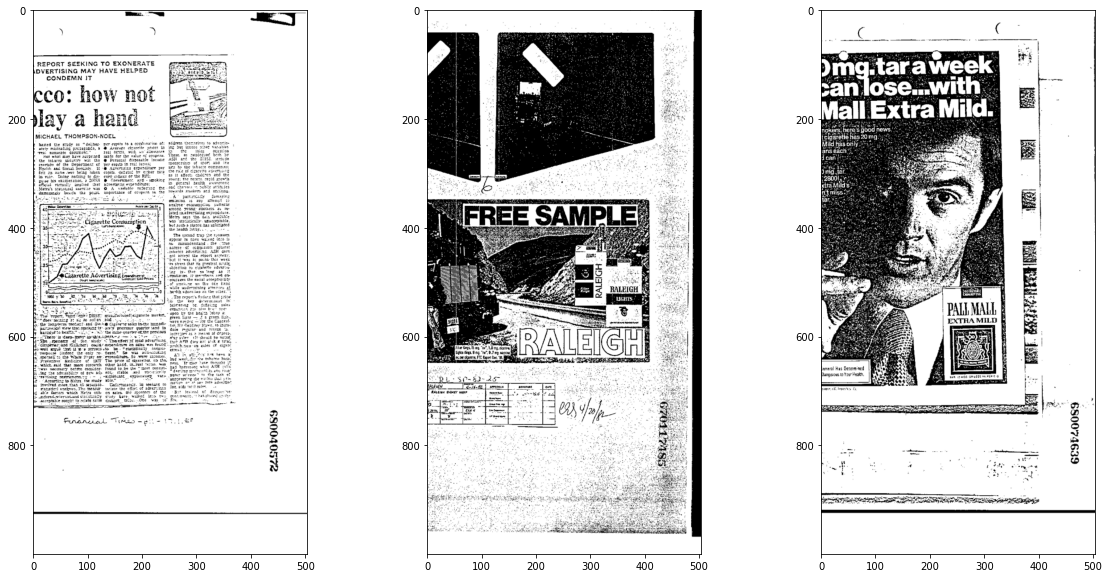

In [28]:
#plt.imshow(test[2])
#test[2].shape
f, ax = plt.subplots(1,3, figsize=(20,10))
ax[0].imshow((train[5]),cmap='gray')
ax[1].imshow((test[5]),cmap='gray')
ax[2].imshow((val[5]),cmap='gray')
plt.show()

In [14]:
pwd

'/home/ec2-user/SageMaker'

## Encoder

In [7]:
input_img = Input(shape=(height, width, 3))
latentDimension = 512
#x = Sequential()
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

#x = Flatten()(x)
encoded = Dense(latentDimension)(x)

## Decoder 

In [8]:
#x = Reshape((14,14,1), input_shape=(input_img,))(encoded)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)
#decoded = MaxPooling2D((2, 2), padding='same')(x)
#decoded = Flatten()(x)

## Compile, model, and summarize

In [9]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mse')
autoencoder.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000, 504, 3)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 504, 32)     896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 500, 252, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 500, 252, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 250, 126, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 250, 126, 128)     73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 125, 63, 128)      0         
_________

## Set Callbacks

In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint = ModelCheckpoint(filepath='logs/adMAX_5Kencoded_decoded_weights.h5', monitor='loss', verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(patience=10)
#tf.keras.callbacks.TensorBoard(log_dir='logs', histogram_freq=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(tensorflow_logs_path,histogram_freq=1)
aws_region = sagemaker_session.boto_region_name
AWS_REGION={aws_region} 
!tensorboard --logdir {tensorflow_logs_path}

In [40]:
autoencoder = load_model('adModel5k-max.h5')

In [ ]:
autoencoder.fit(
            trainData,trainData,
            epochs=epochs,
            batch_size= batch_size,
            shuffle=True,
            validation_data=(valData,valData),
            verbose=1,
            callbacks=[checkpoint])

Train on 1000 samples, validate on 300 samples
Epoch 1/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0210 - val_loss: 0.0198

Epoch 00001: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0212 - val_loss: 0.0195

Epoch 00002: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 3/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0209 - val_loss: 0.0196

Epoch 00003: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 4/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0219 - val_loss: 0.0196

Epoch 00004: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 5/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0207 - val_loss: 0.0198

Epoch 00005: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 6/5000
1000/1000 [==============================] - 34s 34ms/step -

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0212 - val_loss: 0.0193

Epoch 00047: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 48/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0204 - val_loss: 0.0193

Epoch 00048: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 49/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0205 - val_loss: 0.0194

Epoch 00049: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 50/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0207 - val_loss: 0.0193

Epoch 00050: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 51/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0206 - val_loss: 0.0194

Epoch 00051: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 52/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0207 - val_loss: 0.0276

Epoch 00052: saving m

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0199 - val_loss: 0.0187

Epoch 00139: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 140/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0202 - val_loss: 0.0198

Epoch 00140: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 141/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0199 - val_loss: 0.0192

Epoch 00141: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 142/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0199 - val_loss: 0.0193

Epoch 00142: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 143/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0199 - val_loss: 0.0188

Epoch 00143: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 144/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0201 - val_loss: 0.0185

Epoch 00144: sav

1000/1000 [==============================] - 33s 33ms/step - loss: 0.0193 - val_loss: 0.0188

Epoch 00231: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 232/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0195 - val_loss: 0.0182

Epoch 00232: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 233/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0196 - val_loss: 0.0182

Epoch 00233: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 234/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0195 - val_loss: 0.0181

Epoch 00234: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 235/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0193 - val_loss: 0.0183

Epoch 00235: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 236/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0193 - val_loss: 0.0181

Epoch 00236: sav

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0190 - val_loss: 0.0190

Epoch 00323: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 324/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0190 - val_loss: 0.0181

Epoch 00324: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 325/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0190 - val_loss: 0.0178

Epoch 00325: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 326/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0189 - val_loss: 0.0178

Epoch 00326: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 327/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0191 - val_loss: 0.0177

Epoch 00327: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 328/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0187 - val_loss: 0.0178

Epoch 00328: sav

1000/1000 [==============================] - 33s 33ms/step - loss: 0.0186 - val_loss: 0.0174

Epoch 00415: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 416/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0185 - val_loss: 0.0176

Epoch 00416: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 417/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0186 - val_loss: 0.0173

Epoch 00417: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 418/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0184 - val_loss: 0.0177

Epoch 00418: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 419/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0184 - val_loss: 0.0172

Epoch 00419: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 420/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0185 - val_loss: 0.0182

Epoch 00420: sav

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0168 - val_loss: 0.0164

Epoch 00887: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 888/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0170 - val_loss: 0.0160

Epoch 00888: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 889/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0167 - val_loss: 0.0160

Epoch 00889: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 890/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0168 - val_loss: 0.0160

Epoch 00890: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 891/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0169 - val_loss: 0.0179

Epoch 00891: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 892/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0167 - val_loss: 0.0159

Epoch 00892: sav

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0166 - val_loss: 0.0159

Epoch 00979: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 980/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0167 - val_loss: 0.0157

Epoch 00980: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 981/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0165 - val_loss: 0.0163

Epoch 00981: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 982/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0167 - val_loss: 0.0160

Epoch 00982: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 983/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0166 - val_loss: 0.0157

Epoch 00983: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 984/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0166 - val_loss: 0.0158

Epoch 00984: sav

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0166 - val_loss: 0.0159

Epoch 01025: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1026/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0164 - val_loss: 0.0160

Epoch 01026: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1027/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0165 - val_loss: 0.0158

Epoch 01027: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1028/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0171 - val_loss: 0.0181

Epoch 01028: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1029/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0165 - val_loss: 0.0156

Epoch 01029: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1030/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0165 - val_loss: 0.0159

Epoch 01030

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0164 - val_loss: 0.0156

Epoch 01071: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1072/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0164 - val_loss: 0.0156

Epoch 01072: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1073/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0164 - val_loss: 0.0159

Epoch 01073: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1074/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0165 - val_loss: 0.0158

Epoch 01074: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1075/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0163 - val_loss: 0.0157

Epoch 01075: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1076/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0164 - val_loss: 0.0157

Epoch 01076

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0164 - val_loss: 0.0156

Epoch 01117: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1118/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0163 - val_loss: 0.0157

Epoch 01118: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1119/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0165 - val_loss: 0.0158

Epoch 01119: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1120/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0163 - val_loss: 0.0155

Epoch 01120: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1121/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0163 - val_loss: 0.0157

Epoch 01121: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1122/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0163 - val_loss: 0.0157

Epoch 01122

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0162 - val_loss: 0.0159

Epoch 01163: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1164/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0162 - val_loss: 0.0160

Epoch 01164: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1165/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0539 - val_loss: 0.0294

Epoch 01165: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1166/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0205 - val_loss: 0.0167

Epoch 01166: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1167/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0173 - val_loss: 0.0159

Epoch 01167: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1168/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0173 - val_loss: 0.0165

Epoch 01168

1000/1000 [==============================] - 33s 33ms/step - loss: 0.0162 - val_loss: 0.0169

Epoch 01209: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1210/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0163 - val_loss: 0.0153

Epoch 01210: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1211/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0161 - val_loss: 0.0153

Epoch 01211: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1212/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0162 - val_loss: 0.0155

Epoch 01212: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1213/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0162 - val_loss: 0.0155

Epoch 01213: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1214/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0161 - val_loss: 0.0154

Epoch 01214

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0161

Epoch 01255: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1256/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0161 - val_loss: 0.0152

Epoch 01256: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1257/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0162 - val_loss: 0.0174

Epoch 01257: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1258/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0161 - val_loss: 0.0154

Epoch 01258: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1259/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0161 - val_loss: 0.0154

Epoch 01259: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1260/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0160

Epoch 01260

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0152

Epoch 01301: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1302/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0159 - val_loss: 0.0152

Epoch 01302: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1303/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0152

Epoch 01303: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1304/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0161 - val_loss: 0.0167

Epoch 01304: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1305/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0161 - val_loss: 0.0152

Epoch 01305: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1306/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0159 - val_loss: 0.0162

Epoch 01306

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0159 - val_loss: 0.0153

Epoch 01347: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1348/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0159 - val_loss: 0.0152

Epoch 01348: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1349/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0161 - val_loss: 0.0162

Epoch 01349: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1350/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0153

Epoch 01350: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1351/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0159 - val_loss: 0.0152

Epoch 01351: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1352/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0153

Epoch 01352

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0159 - val_loss: 0.0152

Epoch 01393: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1394/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0158 - val_loss: 0.0153

Epoch 01394: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1395/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0164

Epoch 01395: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1396/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0158 - val_loss: 0.0153

Epoch 01396: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1397/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0159 - val_loss: 0.0151

Epoch 01397: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1398/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0161 - val_loss: 0.0156

Epoch 01398

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0158 - val_loss: 0.0151

Epoch 01439: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1440/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0161 - val_loss: 0.0151

Epoch 01440: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1441/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0157 - val_loss: 0.0151

Epoch 01441: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1442/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0159 - val_loss: 0.0169

Epoch 01442: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1443/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0159 - val_loss: 0.0151

Epoch 01443: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1444/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0158 - val_loss: 0.0151

Epoch 01444

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0160 - val_loss: 0.0149

Epoch 01485: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1486/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0157 - val_loss: 0.0172

Epoch 01486: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1487/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0158 - val_loss: 0.0150

Epoch 01487: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1488/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0157 - val_loss: 0.0151

Epoch 01488: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1489/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0158 - val_loss: 0.0149

Epoch 01489: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1490/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0157 - val_loss: 0.0153

Epoch 01490

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0148

Epoch 01531: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1532/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0150

Epoch 01532: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1533/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0157 - val_loss: 0.0160

Epoch 01533: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1534/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0149

Epoch 01534: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1535/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0157 - val_loss: 0.0151

Epoch 01535: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1536/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0158 - val_loss: 0.0152

Epoch 01536

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0150

Epoch 01577: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1578/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0148

Epoch 01578: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1579/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0149

Epoch 01579: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1580/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0150

Epoch 01580: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1581/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0156 - val_loss: 0.0149

Epoch 01581: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1582/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0155 - val_loss: 0.0148

Epoch 01582

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0149

Epoch 01623: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1624/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0154

Epoch 01624: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1625/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0148

Epoch 01625: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1626/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0156 - val_loss: 0.0149

Epoch 01626: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1627/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0148

Epoch 01627: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1628/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0150

Epoch 01628

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0149

Epoch 01669: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1670/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0157 - val_loss: 0.0193

Epoch 01670: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1671/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0148

Epoch 01671: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1672/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0154 - val_loss: 0.0150

Epoch 01672: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1673/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0150

Epoch 01673: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1674/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0150

Epoch 01674

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0149

Epoch 01715: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1716/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0155

Epoch 01716: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1717/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0148

Epoch 01717: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1718/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0148

Epoch 01718: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1719/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0147

Epoch 01719: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1720/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0149

Epoch 01720

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0155 - val_loss: 0.0146

Epoch 01761: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1762/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0154 - val_loss: 0.0146

Epoch 01762: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1763/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0147

Epoch 01763: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1764/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0151

Epoch 01764: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1765/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0148

Epoch 01765: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1766/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0146

Epoch 01766

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0153 - val_loss: 0.0148

Epoch 01807: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1808/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0162

Epoch 01808: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1809/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0149

Epoch 01809: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1810/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0154 - val_loss: 0.0146

Epoch 01810: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1811/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0148

Epoch 01811: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1812/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0154 - val_loss: 0.0145

Epoch 01812

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0153 - val_loss: 0.0146

Epoch 01853: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1854/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0157

Epoch 01854: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1855/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0153 - val_loss: 0.0153

Epoch 01855: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1856/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0174

Epoch 01856: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1857/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0145

Epoch 01857: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1858/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0153 - val_loss: 0.0146

Epoch 01858

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0145

Epoch 01899: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1900/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0149

Epoch 01900: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1901/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0151

Epoch 01901: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1902/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0145

Epoch 01902: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1903/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0154

Epoch 01903: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1904/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0144

Epoch 01904

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0153 - val_loss: 0.0146

Epoch 01945: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1946/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0144

Epoch 01946: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1947/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0148

Epoch 01947: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1948/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0152 - val_loss: 0.0146

Epoch 01948: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1949/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0153

Epoch 01949: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1950/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0145

Epoch 01950

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0146

Epoch 01991: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1992/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0148

Epoch 01992: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1993/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0146

Epoch 01993: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1994/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0144

Epoch 01994: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1995/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0151

Epoch 01995: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 1996/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0146

Epoch 01996

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0147

Epoch 02037: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2038/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0145

Epoch 02038: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2039/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0143

Epoch 02039: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2040/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0144

Epoch 02040: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2041/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0167

Epoch 02041: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2042/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0144

Epoch 02042

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0143

Epoch 02083: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2084/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0145

Epoch 02084: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2085/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0145

Epoch 02085: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2086/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0152 - val_loss: 0.0160

Epoch 02086: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2087/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0149

Epoch 02087: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2088/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0143

Epoch 02088

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0142

Epoch 02129: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2130/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0142

Epoch 02130: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2131/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0143

Epoch 02131: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2132/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0144

Epoch 02132: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2133/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0145

Epoch 02133: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2134/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0144

Epoch 02134

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0143

Epoch 02224: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2225/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0143

Epoch 02225: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2226/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0149

Epoch 02226: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2227/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0151

Epoch 02227: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2228/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0144

Epoch 02228: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2229/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0148 - val_loss: 0.0143

Epoch 02229

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0146

Epoch 02270: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2271/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0147

Epoch 02271: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2272/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0143

Epoch 02272: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2273/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0144

Epoch 02273: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2274/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0142

Epoch 02274: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2275/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0142

Epoch 02275

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0143

Epoch 02316: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2317/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0151 - val_loss: 0.0141

Epoch 02317: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2318/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0142

Epoch 02318: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2319/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0141

Epoch 02319: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2320/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0147

Epoch 02320: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2321/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0145

Epoch 02321

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0142

Epoch 02362: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2363/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0150 - val_loss: 0.0144

Epoch 02363: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2364/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0141

Epoch 02364: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2365/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0142

Epoch 02365: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2366/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0142

Epoch 02366: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2367/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0141

Epoch 02367

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0141

Epoch 02408: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2409/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0141

Epoch 02409: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2410/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0141

Epoch 02410: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2411/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0149 - val_loss: 0.0146

Epoch 02411: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2412/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0141

Epoch 02412: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2413/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0141

Epoch 02413

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0140

Epoch 02454: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2455/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0140

Epoch 02455: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2456/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0142

Epoch 02456: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2457/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0145

Epoch 02457: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2458/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0141

Epoch 02458: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2459/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0147 - val_loss: 0.0145

Epoch 02459

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0149

Epoch 02500: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2501/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0142

Epoch 02501: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2502/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0140

Epoch 02502: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2503/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0141

Epoch 02503: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2504/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0140

Epoch 02504: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2505/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0147 - val_loss: 0.0154

Epoch 02505

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0141

Epoch 02546: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2547/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0148

Epoch 02547: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2548/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0149

Epoch 02548: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2549/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0151

Epoch 02549: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2550/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0147 - val_loss: 0.0142

Epoch 02550: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2551/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0139

Epoch 02551

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0146

Epoch 02592: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2593/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0139

Epoch 02593: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2594/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0139

Epoch 02594: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2595/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0141

Epoch 02595: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2596/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0142

Epoch 02596: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2597/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0140

Epoch 02597

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0139

Epoch 02638: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2639/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0140

Epoch 02639: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2640/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0145 - val_loss: 0.0144

Epoch 02640: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2641/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0145 - val_loss: 0.0140

Epoch 02641: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2642/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0139

Epoch 02642: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2643/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0140

Epoch 02643

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0140

Epoch 02684: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2685/5000
1000/1000 [==============================] - 35s 35ms/step - loss: 0.0144 - val_loss: 0.0145

Epoch 02685: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2686/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0146 - val_loss: 0.0141

Epoch 02686: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2687/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0145 - val_loss: 0.0139

Epoch 02687: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2688/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0145 - val_loss: 0.0143

Epoch 02688: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2689/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0145 - val_loss: 0.0138

Epoch 02689

1000/1000 [==============================] - 34s 34ms/step - loss: 0.0148 - val_loss: 0.0152

Epoch 02730: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2731/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0145 - val_loss: 0.0139

Epoch 02731: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2732/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0145 - val_loss: 0.0138

Epoch 02732: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2733/5000
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0145 - val_loss: 0.0142

Epoch 02733: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2734/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0143 - val_loss: 0.0139

Epoch 02734: saving model to logs/adMAX_5Kencoded_decoded_weights.h5
Epoch 2735/5000
1000/1000 [==============================] - 34s 34ms/step - loss: 0.0147 - val_loss: 0.0140

Epoch 02735

KeyboardInterrupt: 

In [42]:
autoencoder.save('adModel5k-max.h5')

## Apply Model to Test data

In [43]:
#autoencoder.load_weights('./adModel2.h5')
prediction = autoencoder.predict(testData, steps=1, )

In [44]:
len(prediction)

10

In [45]:
prediction[0].shape

(1000, 504, 3)

In [46]:
prediction[0].dtype

dtype('float32')

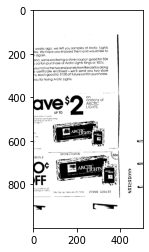

In [47]:
plt.imshow(test[0])

In [1]:
f, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(test[0])
ax[1].imshow(prediction[0])
plt.show()

NameError: name 'plt' is not defined

## OCR NOTES 
Like images, i'm able to read from the original file in and pull characters. I am still not able to OCR the model images for comparison. I think this problem is similar to the image rendering one. 

In [ ]:

#otext = pytesseract.image_to_string(Image.open(test[0]))

In [ ]:
#ntext = pytesseract.image_to_string(prediction[0])

In [ ]:
#print(otext)